# Step Forward Cross Validation for Bioactivity Prediction

## Implementation of Sorted Step Forward Cross Validation Class

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("../benchmark/data/processed/target_CHEMBL1865-1.IC50.csv")

### Sorted Step Forward Cross Validation

#### Case 1: Split by Order (MCE18)
#### Case 2: Split by Order and Ideal Range (LogP, LogD -> ideal range: (0, 3))

In [3]:
class SortedStepForwardCV:
    def __init__(self, sorting_col, ideal=None, n_bins=10, ascending=True):
        self.sorting_col = sorting_col
        self.ideal = ideal
        self.n_bins = n_bins
        self.ascending = ascending

    def _sort_indices(self, df):
        if self.ideal is not None:
            # Compute the absolute distance from the ideal value.
            distances = (df[self.sorting_col] - self.ideal).abs()
            # Stable sort based on distance (lower is better)
            sorted_idx = np.argsort(distances, kind="stable")
        else:
            # Use the property value directly, taking into account the desired order.
            sorted_idx = np.argsort(df[self.sorting_col].values, kind="stable")
        if not self.ascending:
            sorted_idx = sorted_idx[::-1]
        return sorted_idx

    def _create_bins(self, sorted_idx):
        n = len(sorted_idx)
        # Determine bin sizes: use np.array_split to handle duplicates and non-divisible sizes gracefully.
        bins = np.array_split(sorted_idx, self.n_bins)
        return bins

    def split(self, df):
        sorted_idx = self._sort_indices(df)
        bins = self._create_bins(sorted_idx)
        n_bins = len(bins)

        for i in range(1, n_bins):
            train_idx = np.concatenate(bins[:i])
            test_idx = bins[i]
            yield train_idx, test_idx

In [4]:
def plot_train_test_split(df, cv):
    fold_numbers = []
    train_counts = []
    test_counts = []

    # Loop over the folds to record counts.
    for fold, (train_idx, test_idx) in enumerate(cv.split(df), start=1):
        fold_numbers.append(fold)
        train_counts.append(len(train_idx))
        test_counts.append(len(test_idx))

    # Create the stacked bar plot.
    fig, ax = plt.subplots(figsize=(8, 6))
    width = 0.5
    x = fold_numbers

    # Plot training counts.
    train_bars = ax.bar(x, train_counts, width, label='Train', color='C0')
    # Plot test counts stacked on top of training counts.
    test_bars = ax.bar(x, test_counts, width, bottom=train_counts, label='Test', color='C1')

    # Annotate each bar with count and percentage.
    for i, (t_count, ts_count) in enumerate(zip(train_counts, test_counts)):
        total = len(df)
        train_pct = t_count / total * 100
        test_pct = ts_count / total * 100
        # Annotate train section.
        ax.text(x[i], t_count / 2, f'{t_count}\n{train_pct:.1f}%',
                ha='center', va='center', color='black', fontsize=9)
        # Annotate test section.
        ax.text(x[i], t_count + ts_count / 2, f'{ts_count}\n{test_pct:.1f}%',
                ha='center', va='center', color='black', fontsize=9)

    ax.set_xlabel('Fold Number', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Train vs Test Sample Fractions per Fold', fontsize=14)
    # ax.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def plot_property_distribution(df, cv):
    # Prepare a DataFrame to hold the sorting variable values by fold and split.
    data_list = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(df), start=1):
        # For the training set (note: folds are cumulative)
        for idx in train_idx:
            data_list.append({'Fold': fold, 'Split': 'Train', 'Value': df.loc[idx, cv.sorting_col]})
        # For the test set (each fold’s test bin is disjoint)
        for idx in test_idx:
            data_list.append({'Fold': fold, 'Split': 'Test', 'Value': df.loc[idx, cv.sorting_col]})

    plot_df = pd.DataFrame(data_list)

    plt.figure(figsize=(10, 6))
    # Create a box plot grouped by Fold and split type.
    sns.boxplot(x='Fold', y='Value', hue='Split', data=plot_df, showfliers=False, palette="Set2")
    # Overlay a strip plot with jitter.
    sns.stripplot(x='Fold', y='Value', hue='Split', data=plot_df,
                  dodge=True, jitter=True, alpha=0.5, palette='dark:black')

    # To avoid duplicate legend entries, remove the extra one.
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], title='Split', bbox_to_anchor=(1.05, 1), loc=2)

    plt.title(f'Distribution of {cv.sorting_col} per Fold', fontsize=14)
    plt.ylabel(cv.sorting_col, fontsize=12)
    plt.xlabel('Fold Number', fontsize=12)
    plt.tight_layout()
    plt.savefig(
        f'../benchmark/results/figures/{cv.__class__.__name__}_distribution_of_{cv.sorting_col}.svg')
    plt.show()

In [6]:
logd_ssfcv = SortedStepForwardCV(sorting_col='LogD', ideal=2, n_bins=10, ascending=False)
logp_ssfcv = SortedStepForwardCV(sorting_col='LogP', ideal=2, n_bins=10, ascending=False)
mce18_ssfcv = SortedStepForwardCV(sorting_col='MCE18', n_bins=10, ascending=True)

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


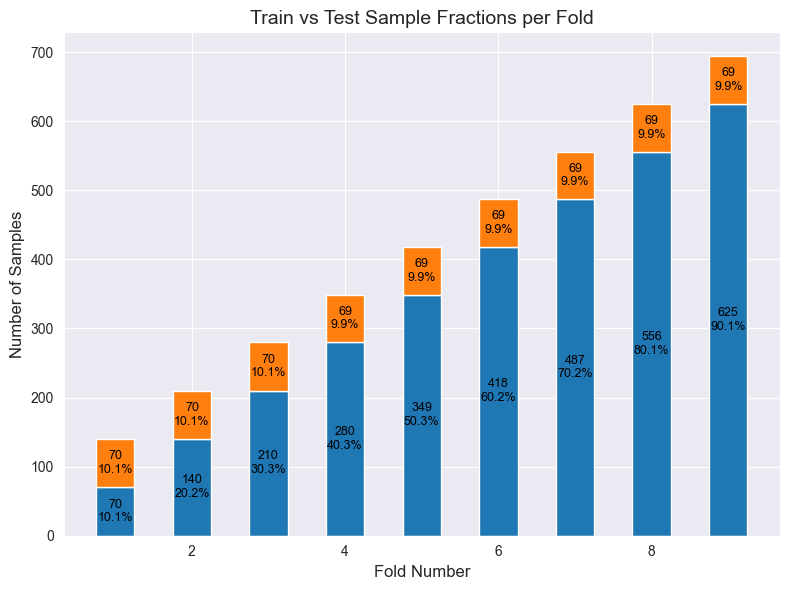

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


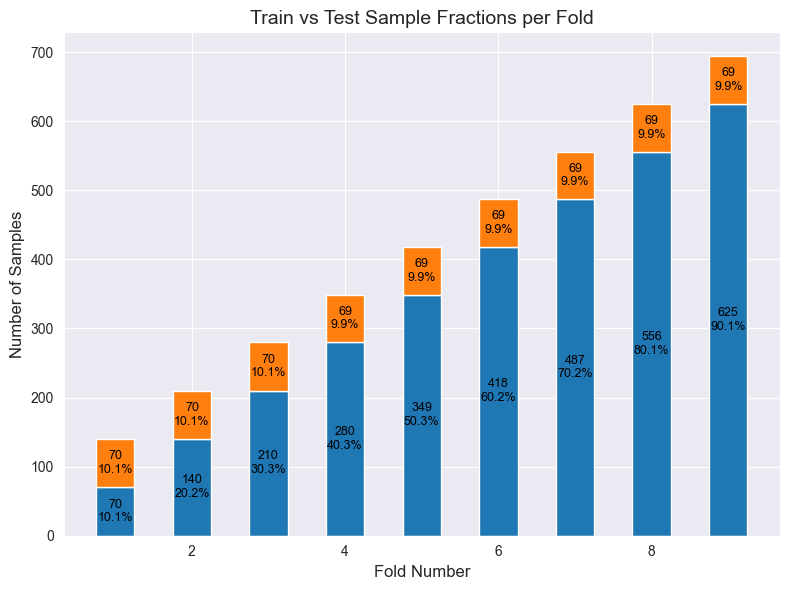

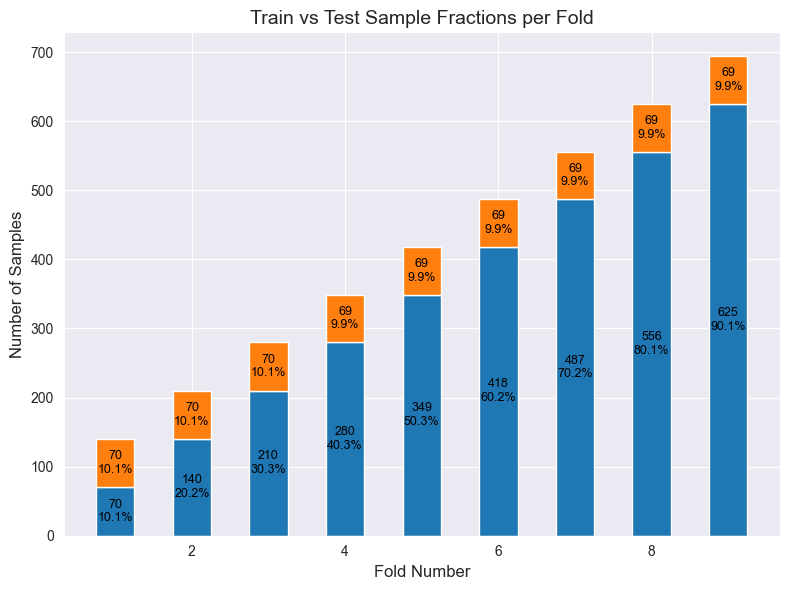

In [7]:
plot_train_test_split(df, logd_ssfcv)
plot_train_test_split(df, logp_ssfcv)
plot_train_test_split(df, mce18_ssfcv)

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


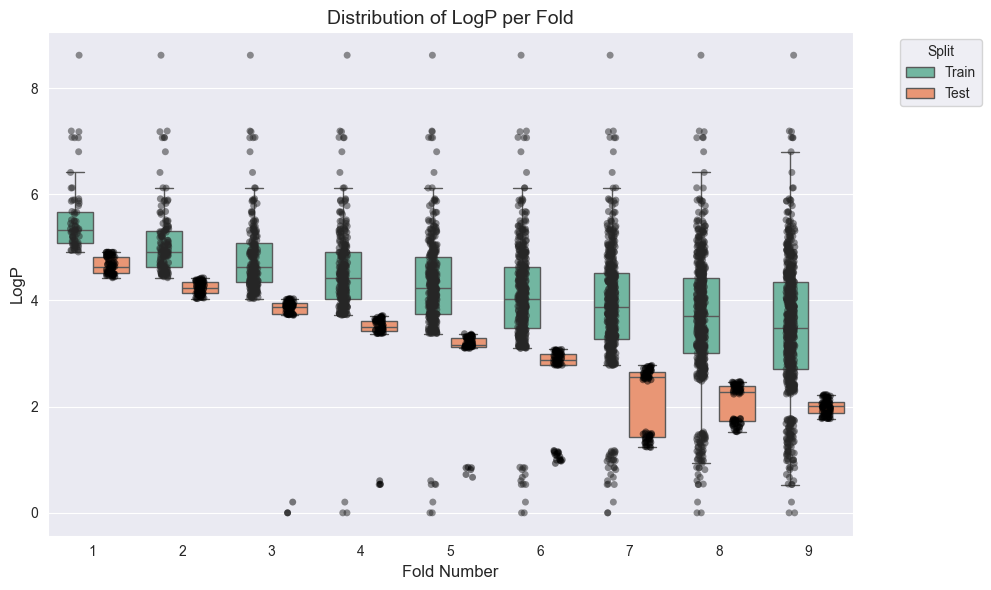

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


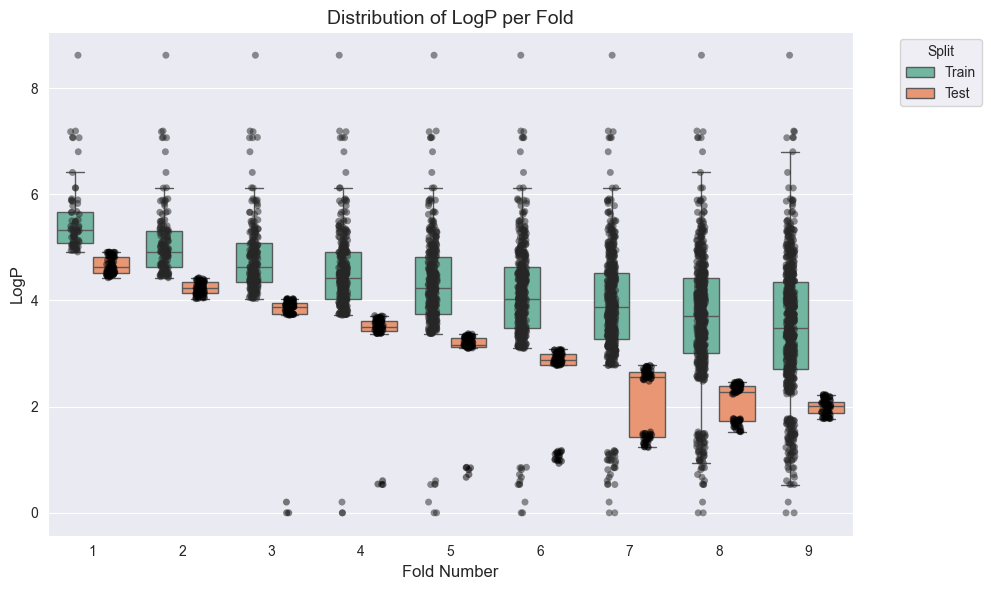

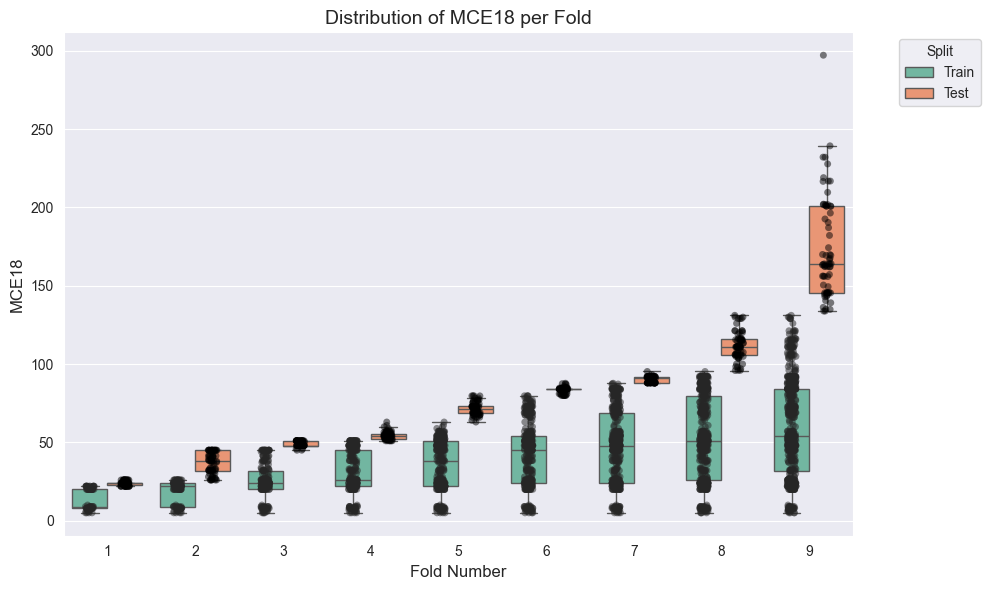

In [8]:
plot_property_distribution(df, logp_ssfcv)
plot_property_distribution(df, logp_ssfcv)
plot_property_distribution(df, mce18_ssfcv)

## Implementation of Unsorted Step Forward Cross Validation Class

In [9]:
class UnsortedSFCV:
    def __init__(self, n_bins=10, random_state=69420):
        self.n_bins = n_bins
        self.random_state = random_state

    def _shuffle_indices(self, df):
        indices = np.arange(len(df))
        rng = np.random.default_rng(self.random_state)
        rng.shuffle(indices)
        return indices

    def _create_bins(self, shuffled_idx):
        bins = np.array_split(shuffled_idx, self.n_bins)
        return bins

    def split(self, df):
        shuffled_idx = self._shuffle_indices(df)
        bins = self._create_bins(shuffled_idx)
        n_bins = len(bins)

        for i in range(1, n_bins):
            train_idx = np.concatenate(bins[:i])
            test_idx = bins[i]
            yield train_idx, test_idx

In [10]:
unsorted_sfcv = UnsortedSFCV(n_bins=10, random_state=42)

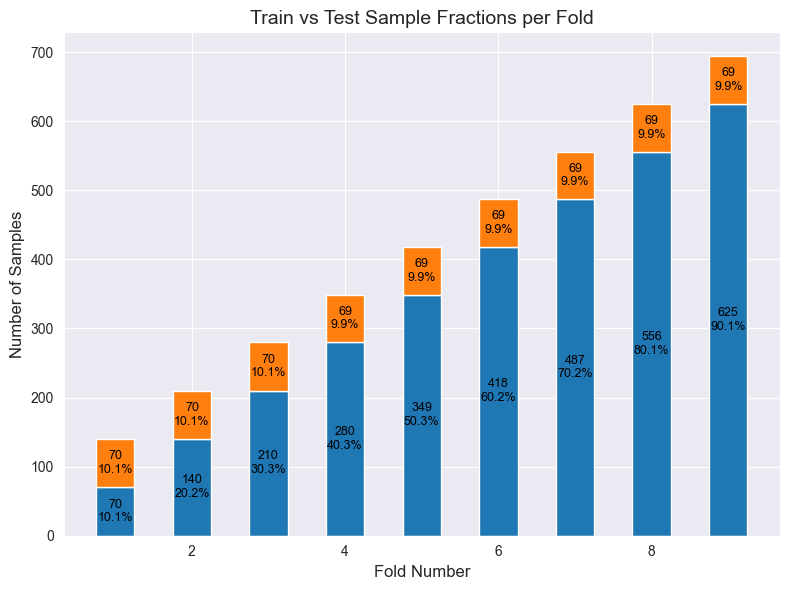

In [11]:
plot_train_test_split(df, unsorted_sfcv)

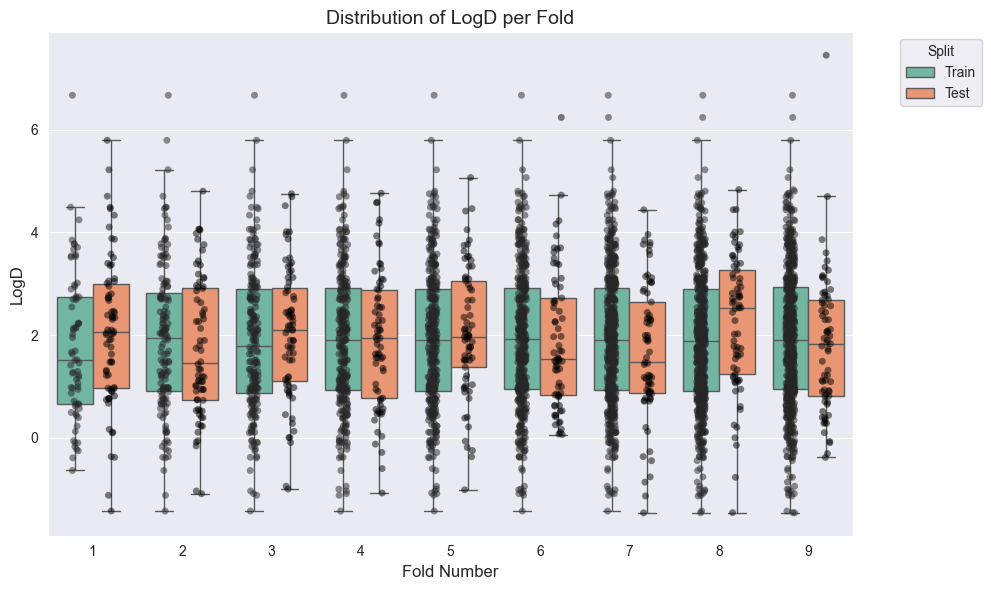

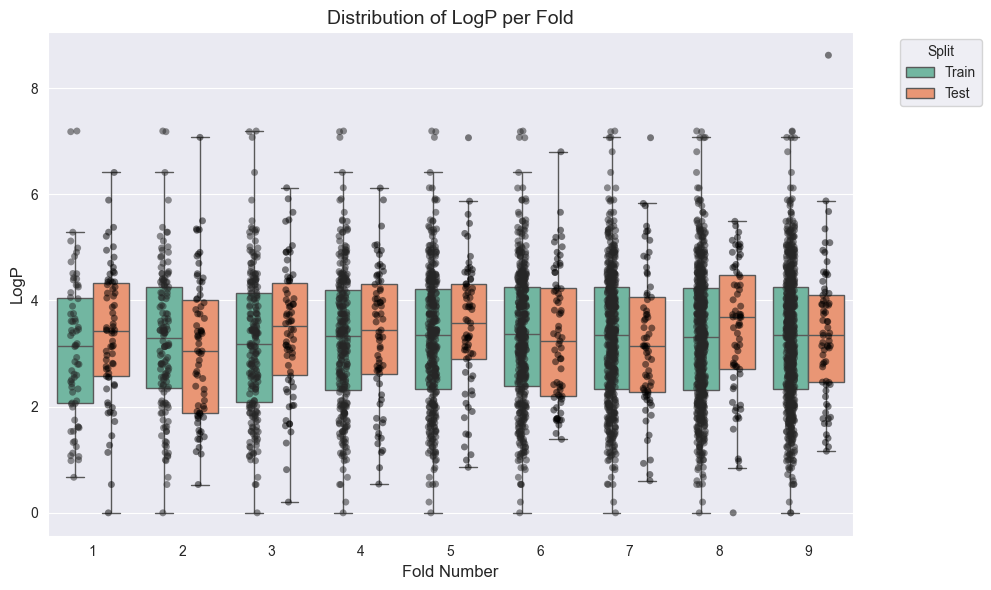

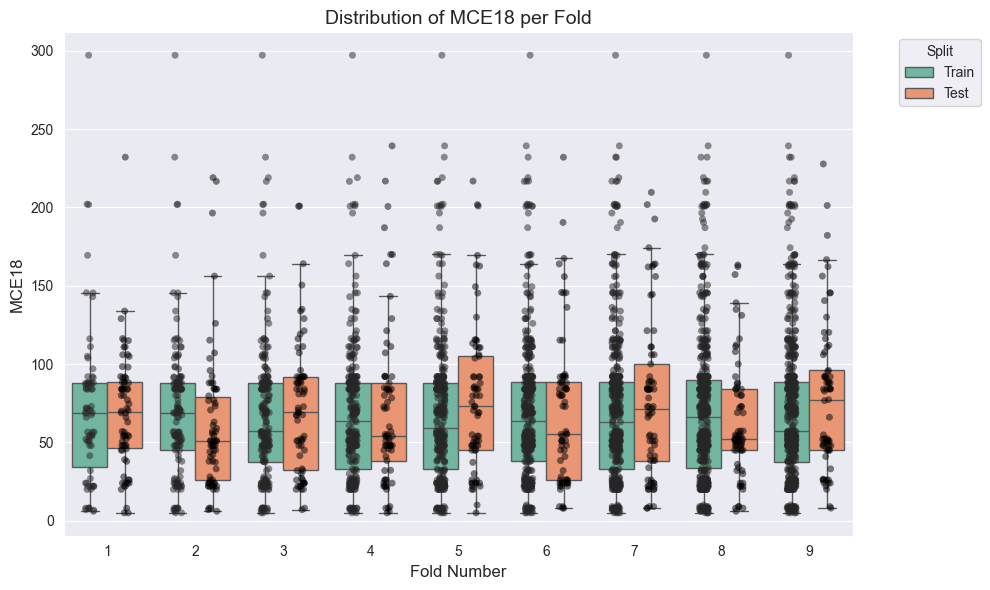

In [12]:
cv = unsorted_sfcv

for param in ["LogD", "LogP", "MCE18"]:
    data_list = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(df), start=1):
        # For the training set (note: folds are cumulative)
        for idx in train_idx:
            data_list.append({'Fold': fold, 'Split': 'Train', 'Value': df.loc[idx, param]})
        # For the test set (each fold’s test bin is disjoint)
        for idx in test_idx:
            data_list.append({'Fold': fold, 'Split': 'Test', 'Value': df.loc[idx, param]})

    plot_df = pd.DataFrame(data_list)

    plt.figure(figsize=(10, 6))
    # Create a box plot grouped by Fold and split type.
    sns.boxplot(x='Fold', y='Value', hue='Split', data=plot_df, showfliers=False, palette="Set2")
    # Overlay a strip plot with jitter.
    sns.stripplot(x='Fold', y='Value', hue='Split', data=plot_df,
                  dodge=True, jitter=True, alpha=0.5, palette='dark:black')

    # To avoid duplicate legend entries, remove the extra one.
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], title='Split', bbox_to_anchor=(1.05, 1), loc=2)

    plt.title(f'Distribution of {param} per Fold', fontsize=14)
    plt.ylabel(param, fontsize=12)
    plt.xlabel('Fold Number', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"../benchmark/results/figures/UnsortedStepForwardCV_distribution_of_{param}.svg")
    plt.show()

In [13]:
print('UNSORTED SFCV')

for i, (train_idx, test_idx) in enumerate(unsorted_sfcv.split(df)):
    print(
        f"Fold [{i + 1}] => Train [{len(train_idx)} ({len(train_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)] + Test [{len(test_idx)} ({len(test_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)]")

UNSORTED SFCV
Fold [1] => Train [70 (50.00%)] + Test [70 (50.00%)]
Fold [2] => Train [140 (66.67%)] + Test [70 (33.33%)]
Fold [3] => Train [210 (75.00%)] + Test [70 (25.00%)]
Fold [4] => Train [280 (80.23%)] + Test [69 (19.77%)]
Fold [5] => Train [349 (83.49%)] + Test [69 (16.51%)]
Fold [6] => Train [418 (85.83%)] + Test [69 (14.17%)]
Fold [7] => Train [487 (87.59%)] + Test [69 (12.41%)]
Fold [8] => Train [556 (88.96%)] + Test [69 (11.04%)]
Fold [9] => Train [625 (90.06%)] + Test [69 (9.94%)]


In [15]:
print("SORTED SFCV")

for i, (train_idx, test_idx) in enumerate(logd_ssfcv.split(df)):
    print(
        f"Fold [{i + 1}] => Train [{len(train_idx)} ({len(train_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)] + Test [{len(test_idx)} ({len(test_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)]")

SORTED SFCV
Fold [1] => Train [70 (50.00%)] + Test [70 (50.00%)]
Fold [2] => Train [140 (66.67%)] + Test [70 (33.33%)]
Fold [3] => Train [210 (75.00%)] + Test [70 (25.00%)]
Fold [4] => Train [280 (80.23%)] + Test [69 (19.77%)]
Fold [5] => Train [349 (83.49%)] + Test [69 (16.51%)]
Fold [6] => Train [418 (85.83%)] + Test [69 (14.17%)]
Fold [7] => Train [487 (87.59%)] + Test [69 (12.41%)]
Fold [8] => Train [556 (88.96%)] + Test [69 (11.04%)]
Fold [9] => Train [625 (90.06%)] + Test [69 (9.94%)]


/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [16]:
print("SORTED SFCV")

for i, (train_idx, test_idx) in enumerate(logp_ssfcv.split(df)):
    print(
        f"Fold [{i + 1}] => Train [{len(train_idx)} ({len(train_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)] + Test [{len(test_idx)} ({len(test_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)]")

SORTED SFCV
Fold [1] => Train [70 (50.00%)] + Test [70 (50.00%)]
Fold [2] => Train [140 (66.67%)] + Test [70 (33.33%)]
Fold [3] => Train [210 (75.00%)] + Test [70 (25.00%)]
Fold [4] => Train [280 (80.23%)] + Test [69 (19.77%)]
Fold [5] => Train [349 (83.49%)] + Test [69 (16.51%)]
Fold [6] => Train [418 (85.83%)] + Test [69 (14.17%)]
Fold [7] => Train [487 (87.59%)] + Test [69 (12.41%)]
Fold [8] => Train [556 (88.96%)] + Test [69 (11.04%)]
Fold [9] => Train [625 (90.06%)] + Test [69 (9.94%)]


/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [17]:
print("SORTED SFCV")

for i, (train_idx, test_idx) in enumerate(mce18_ssfcv.split(df)):
    print(
        f"Fold [{i + 1}] => Train [{len(train_idx)} ({len(train_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)] + Test [{len(test_idx)} ({len(test_idx) / (len(train_idx) + len(test_idx)) * 100:.2f}%)]")

SORTED SFCV
Fold [1] => Train [70 (50.00%)] + Test [70 (50.00%)]
Fold [2] => Train [140 (66.67%)] + Test [70 (33.33%)]
Fold [3] => Train [210 (75.00%)] + Test [70 (25.00%)]
Fold [4] => Train [280 (80.23%)] + Test [69 (19.77%)]
Fold [5] => Train [349 (83.49%)] + Test [69 (16.51%)]
Fold [6] => Train [418 (85.83%)] + Test [69 (14.17%)]
Fold [7] => Train [487 (87.59%)] + Test [69 (12.41%)]
Fold [8] => Train [556 (88.96%)] + Test [69 (11.04%)]
Fold [9] => Train [625 (90.06%)] + Test [69 (9.94%)]
